In [1]:
import numpy as np
from keras import models
from keras import layers

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Data generation
We need a function which can generate with the proper structure.

The data structure is a list of binary module vectors per track

In [2]:
# Config parameters
det_width = 50
det_depth = 50

In [3]:
def sim_track(m, b):
    x = np.zeros([det_depth, det_width])
    hit_idxs = [round(m*l + b) for l in range(det_depth)]
    for row, idx in enumerate(hit_idxs):
        x[row, idx] = 1
    return x

def generate_track():
    """Sample track parameters and simulate propagation to produce hits"""
    b = np.random.random_sample()*(det_width - 1)
    # restrict slope to only generate tracks that traverse the entire detector
    mmax = (det_width - 1 - b) / (det_depth - 1)
    mmin = -b / det_depth
    #print(mmin, mmax)
    m = np.random.random_sample() * (mmax - mmin) + mmin
    #print(m, b)
    return sim_track(m, b)

def generate_tracks(n):
    """Generates N tracks in independent detector images"""
    tracks = [generate_track().reshape([1, det_depth, det_width]) for i in range(n)]
    return np.concatenate(tracks, axis=0)

def generate_noise(n, prob=0.1, skip_layers=5):
    """Generate uniform noise hits with probability prob and skipping some initial seed layers"""
    # One way to do this: generate random floats in [0,1]
    # and then convert the ones above threshold to binary
    noise_events = np.zeros([n, det_depth, det_width])
    noise_events[:,skip_layers:,:] = np.random.random_sample([n, det_depth-skip_layers, det_width]) < prob
    return noise_events

def generate_bkg(num_events, num_tracks=2, seed_layers=5):
    """Generate events with a number of background tracks"""
    # Combine single-track events to make multi-track events
    events = sum([generate_tracks(num_events) for i in range(num_tracks)])
    # Zero the layers used for seeding
    events[:,0:seed_layers,:] = 0
    return events

def generate_events(num_event, tracks_per_event):
    """Generates events with fixed number of tracks"""
    return sum([generate_tracks(num_event) for i in range(tracks_per_event)])

<IPython.core.display.Javascript object>


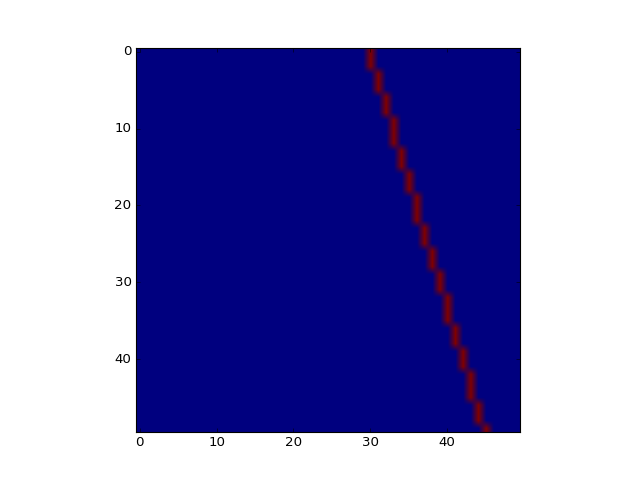

In [4]:
# This is what a track looks like in our "detector"
t = generate_track()
plt.figure()
plt.imshow(t)

In [5]:
# Generate a sample of these single-track events
tracks = generate_tracks(50000)

train_input = tracks[:,:-1,:]
train_target = tracks[:,1:,:]
print(train_input.shape)

(50000, 49, 50)


## Build the track fitting model

In [6]:
def build_model(num_hidden=10, length=det_depth-1, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model    

In [7]:
# Instantiate the model
model1 = build_model()

# Train on the entire training set
model1.fit(train_input, train_target, batch_size=100, nb_epoch=10)

# Get all of the training data predictions
train_pred = model1.predict(train_input)

Epoch 1/10
50000/50000 [==============================] - 125s - loss: 2.2264 - acc: 0.4060   
Epoch 2/10
50000/50000 [==============================] - 122s - loss: 1.0176 - acc: 0.6630   
Epoch 3/10
50000/50000 [==============================] - 122s - loss: 0.8112 - acc: 0.6859   
Epoch 4/10
50000/50000 [==============================] - 123s - loss: 0.7139 - acc: 0.7066   
Epoch 5/10
50000/50000 [==============================] - 122s - loss: 0.6515 - acc: 0.7296   
Epoch 6/10
50000/50000 [==============================] - 121s - loss: 0.6031 - acc: 0.7478   
Epoch 7/10
50000/50000 [==============================] - 121s - loss: 0.5647 - acc: 0.7654   
Epoch 8/10
50000/50000 [==============================] - 121s - loss: 0.5336 - acc: 0.7783   
Epoch 9/10
50000/50000 [==============================] - 122s - loss: 0.5091 - acc: 0.7882   
Epoch 10/10
50000/50000 [==============================] - 121s - loss: 0.4900 - acc: 0.7959   


<IPython.core.display.Javascript object>


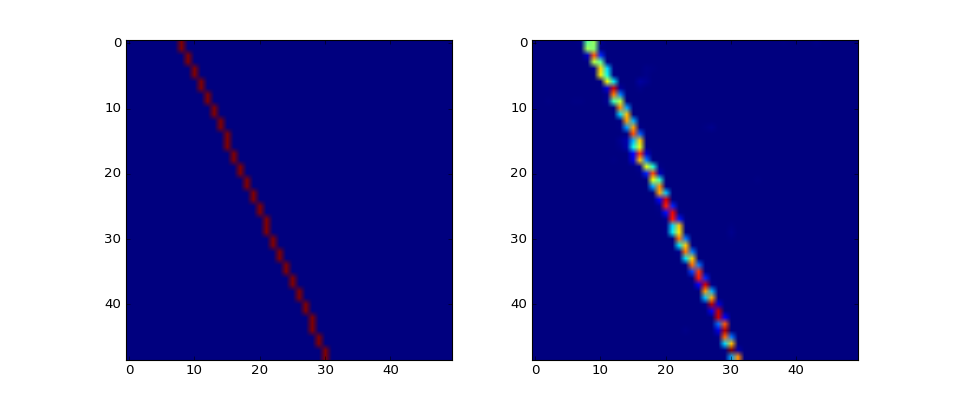

In [28]:
# Display one sample from the training set
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(train_input[display_idx])
plt.subplot(122)
plt.imshow(train_pred[display_idx])

## Two-track events

In [32]:
# Try adding two tracks into one image and see how the model does without any retraining
t1 = generate_track()
t2 = generate_track()
t3 = t1 + t2
t3_input = t3.reshape([1, det_depth, det_width])[:,:-1,:]
t3_pred = model1.predict(t3_input)

<IPython.core.display.Javascript object>


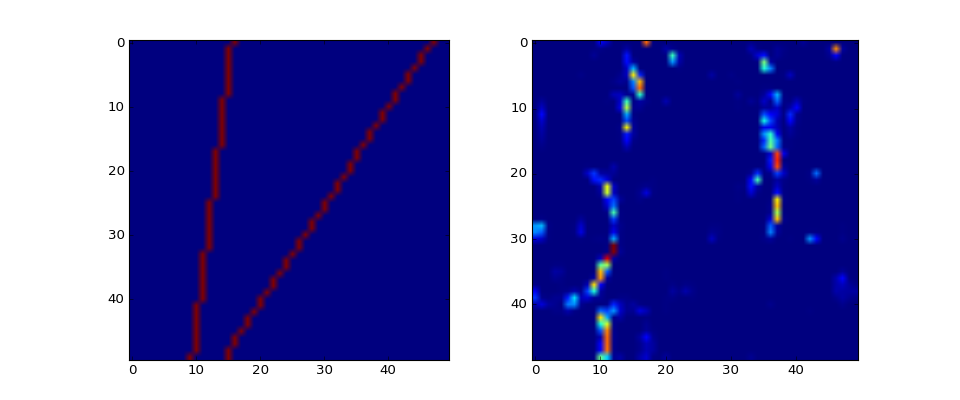

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(t3)
plt.subplot(122)
plt.imshow(t3_pred[0])

In [43]:
# Now lets generate events with 2 tracks each and train on that
events2 = generate_events(50000, 2)
train2_input = events2[:,:-1,:]
train2_target = events2[:,1:,:]

In [35]:
# Create a new model
model2 = build_model(num_hidden=20)
model2.fit(train2_input, train2_target, batch_size=100, nb_epoch=10)
train2_pred = model2.predict(train2_input)

Epoch 1/10
50000/50000 [==============================] - 127s - loss: 4.8534 - acc: 0.2659   
Epoch 2/10
50000/50000 [==============================] - 128s - loss: 3.3298 - acc: 0.3385   
Epoch 3/10
50000/50000 [==============================] - 126s - loss: 3.1795 - acc: 0.3419   
Epoch 4/10
50000/50000 [==============================] - 131s - loss: 3.1083 - acc: 0.3427   
Epoch 5/10
50000/50000 [==============================] - 128s - loss: 3.0606 - acc: 0.3438   
Epoch 6/10
50000/50000 [==============================] - 126s - loss: 3.0240 - acc: 0.3452   
Epoch 7/10
50000/50000 [==============================] - 129s - loss: 2.9938 - acc: 0.3454   
Epoch 8/10
50000/50000 [==============================] - 128s - loss: 2.9680 - acc: 0.3465   
Epoch 9/10
50000/50000 [==============================] - 128s - loss: 2.9463 - acc: 0.3487   
Epoch 10/10
50000/50000 [==============================] - 127s - loss: 2.9281 - acc: 0.3512   


<IPython.core.display.Javascript object>


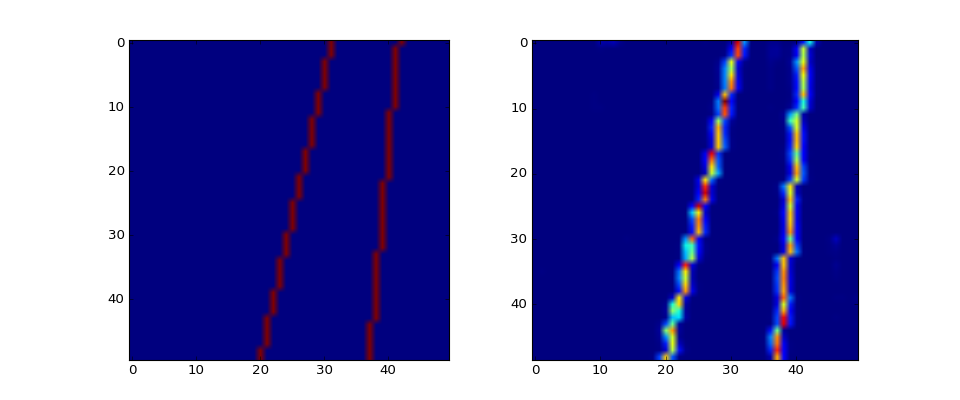

In [45]:
# Display one sample from the training set
display_idx = 666
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events2[display_idx])
plt.subplot(122)
plt.imshow(train2_pred[display_idx])

## Single tracks with uniform noise
In training, the inputs to the network are the events with the tracks and noise. However, in this case the target is the not same event, but rather the track by itself (still shifted by 1 index). Let's see if we can get this to work.

In [37]:
noise = generate_noise(len(tracks), skip_layers=10)
events3 = tracks + noise

<IPython.core.display.Javascript object>


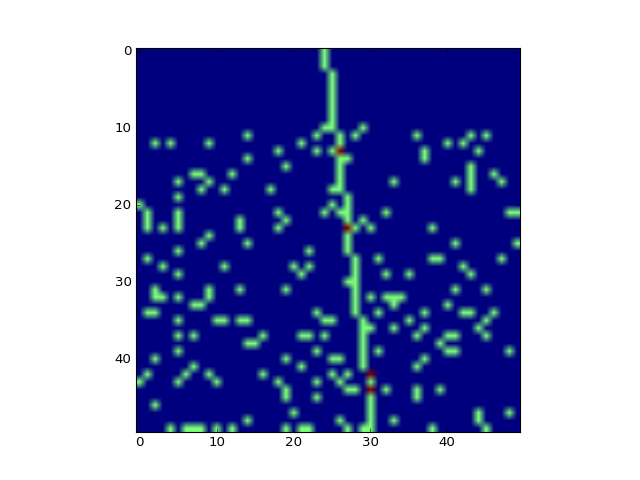

In [38]:
# Let's take a quick look at one of these noise events
plt.figure()
plt.imshow(events3[66])

In [39]:
# Define the inputs and target
train3_input = events3[:,:-1,:]
train3_target = tracks[:,1:,:]

In [40]:
# Instantiate the model
model3 = build_model(num_hidden=20)

# Train the network
model3.fit(train3_input, train3_target, batch_size=100, nb_epoch=10)

# Get the final predictions from the entire training set
train3_pred = model3.predict(train3_input)

Epoch 1/10
50000/50000 [==============================] - 128s - loss: 2.2565 - acc: 0.3341   
Epoch 2/10
50000/50000 [==============================] - 127s - loss: 1.2807 - acc: 0.5480   
Epoch 3/10
50000/50000 [==============================] - 128s - loss: 1.0607 - acc: 0.5992   
Epoch 4/10
50000/50000 [==============================] - 127s - loss: 0.9594 - acc: 0.6228   
Epoch 5/10
50000/50000 [==============================] - 129s - loss: 0.8927 - acc: 0.6388   
Epoch 6/10
50000/50000 [==============================] - 128s - loss: 0.8522 - acc: 0.6488   
Epoch 7/10
50000/50000 [==============================] - 126s - loss: 0.8102 - acc: 0.6627   
Epoch 8/10
50000/50000 [==============================] - 127s - loss: 0.7913 - acc: 0.6689   
Epoch 9/10
50000/50000 [==============================] - 127s - loss: 0.7932 - acc: 0.6724   
Epoch 10/10
50000/50000 [==============================] - 128s - loss: 0.7440 - acc: 0.6847   


<IPython.core.display.Javascript object>


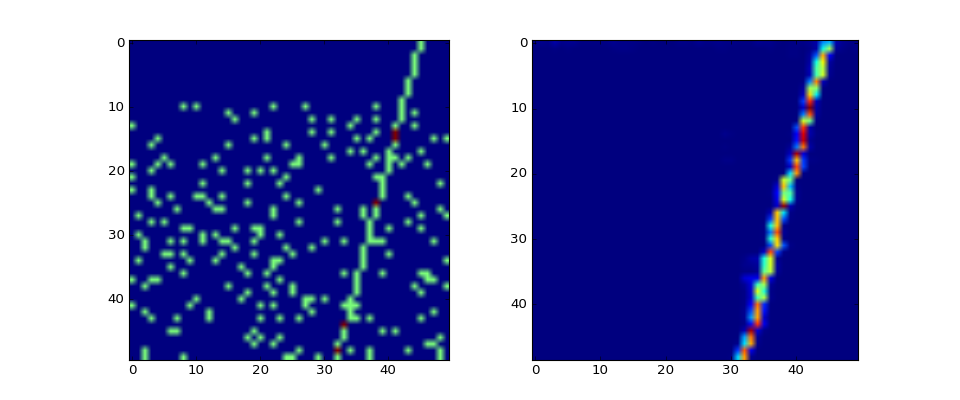

In [41]:
display_idx = 12050
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events3[display_idx])
plt.subplot(122)
plt.imshow(train3_pred[display_idx])

let's try to make it a little more difficult by decreasing the seed size and increasing the noise level

<IPython.core.display.Javascript object>


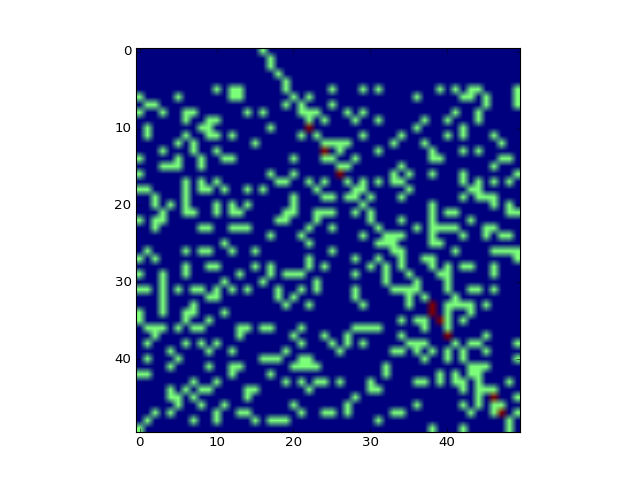

In [46]:
noise = generate_noise(len(tracks), skip_layers=5, prob=0.2)
events4 = tracks + noise
train4_input = events4[:,:-1,:]
train4_target = tracks[:,1:,:]
plt.figure()
plt.imshow(events4[10])

In [47]:
model4 = build_model(num_hidden=20)
model4.fit(train4_input, train4_target, batch_size=100, nb_epoch=10)
train4_pred = model4.predict(train4_input)

Epoch 1/10
50000/50000 [==============================] - 130s - loss: 2.5760 - acc: 0.2363   
Epoch 2/10
50000/50000 [==============================] - 125s - loss: 1.7023 - acc: 0.4019   
Epoch 3/10
50000/50000 [==============================] - 125s - loss: 1.4528 - acc: 0.4702   
Epoch 4/10
50000/50000 [==============================] - 126s - loss: 1.3591 - acc: 0.4990   
Epoch 5/10
50000/50000 [==============================] - 130s - loss: 1.2658 - acc: 0.5235   
Epoch 6/10
50000/50000 [==============================] - 131s - loss: 1.1991 - acc: 0.5424   
Epoch 7/10
50000/50000 [==============================] - 126s - loss: 1.1688 - acc: 0.5539   
Epoch 8/10
50000/50000 [==============================] - 127s - loss: 1.1547 - acc: 0.5598   
Epoch 9/10
50000/50000 [==============================] - 126s - loss: 1.0928 - acc: 0.5743   
Epoch 10/10
50000/50000 [==============================] - 127s - loss: 1.0648 - acc: 0.5825   


<IPython.core.display.Javascript object>


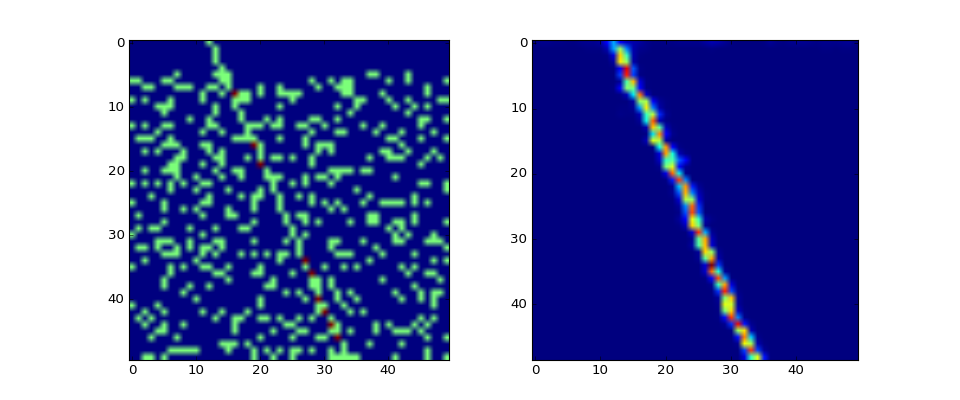

In [49]:
display_idx = 444
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events4[display_idx])
plt.subplot(122)
plt.imshow(train4_pred[display_idx])

<IPython.core.display.Javascript object>


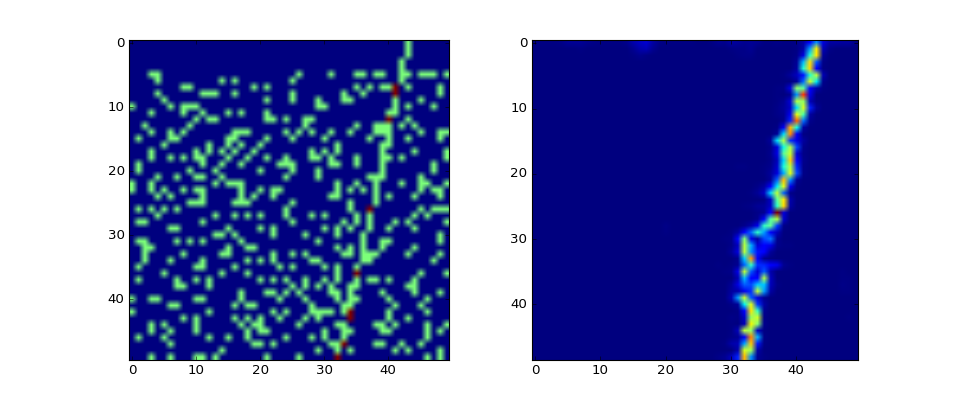

In [57]:
display_idx = 25
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events4[display_idx])
plt.subplot(122)
plt.imshow(train4_pred[display_idx])

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track.

<IPython.core.display.Javascript object>


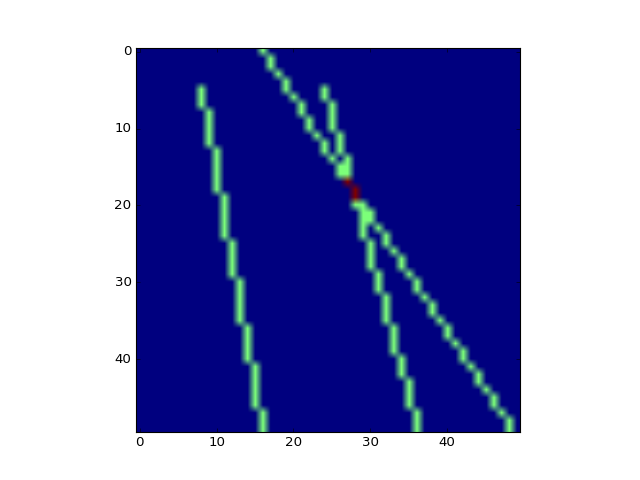

In [51]:
# Generate the bkg data
bkgs = generate_bkg(tracks.shape[0], 2)
events5 = bkgs + tracks
train5_input = events5[:,:-1,:]
train5_target = tracks[:,1:,:]
plt.figure()
plt.imshow(events5[10])

In [52]:
model5 = build_model(num_hidden=20)
model5.fit(train5_input, train5_target, batch_size=100, nb_epoch=10)
train5_pred = model5.predict(train5_input)

Epoch 1/10
50000/50000 [==============================] - 133s - loss: 2.8659 - acc: 0.2423   
Epoch 2/10
50000/50000 [==============================] - 127s - loss: 2.2830 - acc: 0.3725   
Epoch 3/10
50000/50000 [==============================] - 129s - loss: 2.0981 - acc: 0.4133   
Epoch 4/10
50000/50000 [==============================] - 130s - loss: 1.9940 - acc: 0.4311   
Epoch 5/10
50000/50000 [==============================] - 129s - loss: 1.9017 - acc: 0.4473   
Epoch 6/10
50000/50000 [==============================] - 126s - loss: 1.9899 - acc: 0.4181   
Epoch 7/10
50000/50000 [==============================] - 130s - loss: 1.8759 - acc: 0.4342   
Epoch 8/10
50000/50000 [==============================] - 128s - loss: 1.8298 - acc: 0.4448   
Epoch 9/10
50000/50000 [==============================] - 130s - loss: 1.7757 - acc: 0.4501   
Epoch 10/10
50000/50000 [==============================] - 130s - loss: 1.7492 - acc: 0.4503   


<IPython.core.display.Javascript object>


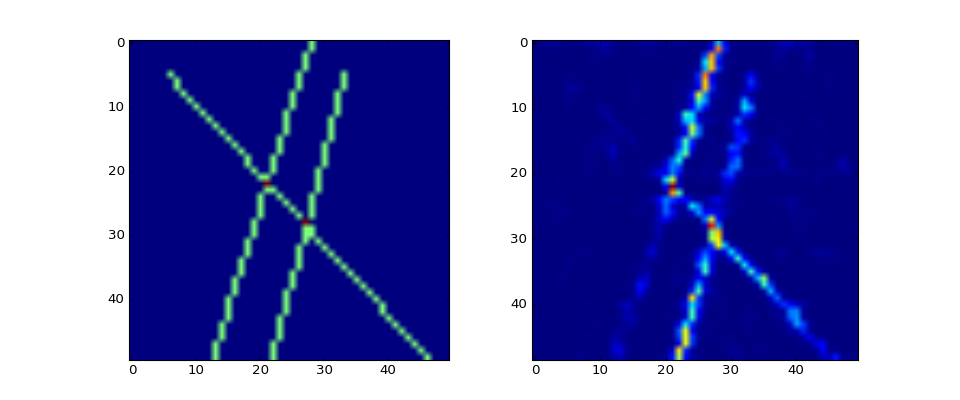

In [58]:
display_idx = 1234
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events5[display_idx])
plt.subplot(122)
plt.imshow(train5_pred[display_idx])

<IPython.core.display.Javascript object>


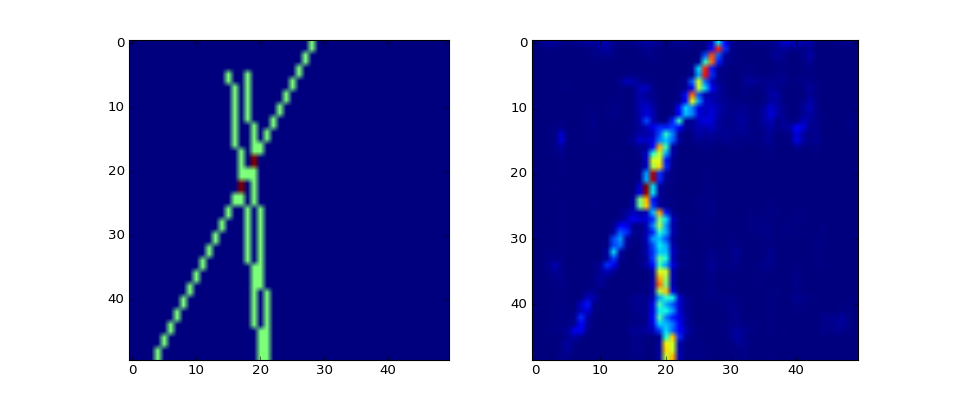

In [60]:
display_idx = 5432
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(events5[display_idx])
plt.subplot(122)
plt.imshow(train5_pred[display_idx])

This doesn't work terribly well, as you can see. I might have to explore beefing up the model and doing more training.